# DeepFake Detection: ResNet Model

**Objective**: Use transfer learning for feature extraction with ResNet50 followed by CNN classification model  

**ResNet 50 Models**: 
1. Binary Classification
2. Multi-Class Classification

In [61]:
import numpy as np
% matplotlib inline
from __future__ import print_function

#Data Processing
from skimage import io
import os
import glob
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

#Neural Networks
from tensorflow.python import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import optimizers

#Models
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

#Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint,Callback
from keras.callbacks import ReduceLROnPlateau

from sklearn import metrics
from tensorflow.keras.models import load_model

## Dataset Split

Load the DeepFake dataset to randomly divide it into train and test set 

In [62]:
# path to your dataset
DATASET_PATH = '/mnt/disks/user/project/Dataset/'
deepfake_class = ['original/clean_frames','FaceSwap/clean_frames', 'Reenactment/clean_frames']

In [63]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def MultiDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        #balancing the dataset
        balance_paths = random.sample(paths,2000)

        brk_point = int(len(balance_paths)*train_ratio)
        for j in range(len(balance_paths)):
            if j <= brk_point:
                train_set.update({balance_paths[j]:i})
            else:
                test_set.update({balance_paths[j]:i})
    
    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [64]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def BinaryDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        if i == 0:
            paths = random.sample(paths,4000)
        else:
            paths = random.sample(paths,2000)
        brk_point = int(len(paths)*train_ratio)
        for j in range(len(paths)):
            if j <= brk_point:
                if i == 0:
                    train_set.update({paths[j]:0})
                else: 
                    train_set.update({paths[j]:1})
            else:
                if i == 0:
                    test_set.update({paths[j]:0})
                else:
                    test_set.update({paths[j]:1})

    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [65]:
b_train_set, b_test_set, b_train_X, b_train_y, b_test_X, b_test_y = BinaryDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [66]:
m_train_set, m_test_set, m_train_X, m_train_y, m_test_X, m_test_y = MultiDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [67]:
Counter(b_train_set.values())

Counter({0: 2801, 1: 2802})

In [68]:
Counter(m_train_set.values())

Counter({0: 1401, 1: 1401, 2: 1401})

In [69]:
set(b_test_set.values())

{0, 1}

In [70]:
set(m_test_set.values())

{0, 1, 2}

In [71]:
# specify image size and channels
img_channels = 3
img_rows = 224
img_cols = 224

# number of classes
b_nb_classes = 2
m_nb_classes = 3

## Data Processing

Divide data into batches and process them

In [72]:
'''
func: prepare and process batch wise data for training/ablation. 
The image path is converted to image data while the classes are label encoded (0,1,2)
input:
    i.image_list: X data: array of image paths
    ii:classes: y data: dictionary of image paths and their corresponding classes
output:
    i. DataGenerator
'''
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_list, classes, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=3,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.classes = classes
        self.image_list = image_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_img_temp = [self.image_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_img_temp)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_img_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization of Y
        y = np.empty((self.batch_size), dtype=int)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X = np.random.rand(self.batch_size, *self.dim, self.n_channels)

        #For each image path in the batch: load it, convert it to array, normalize values and pre-process.
        #Append X and respective y values to the empty X and y variables
        for i, ID in enumerate(list_img_temp):
            img = load_img(ID, target_size=self.dim)
            img = img_to_array(img)
            #img = img/255
            #process = datagen.fit(img)
            img = preprocess_input(img)
            X[i,] = img
            y[i] = self.classes[ID]
            
        #class encoding to 0,1,2
#         le = LabelEncoder()
#         self.y_value = le.fit_transform(y)
        return X,keras.utils.to_categorical(y, num_classes=self.n_classes)

In [73]:
'''
func: get the data generators for training and validation
input:
    i.train_X, test_X: array of image paths in training and testing respectively
    ii.train_set, test_set: dictionary of image paths and their corresponding class for training and test data respectively
    iii. ablation: int: number of training and test entries to use for DataGeneration
output:
    i. training_generator
    ii. validation_generator
'''
def data_generator(train_X, train_set, test_X, test_set,classes,ablation = None):
    #Randomly selecting data in case of ablation testing
    if ablation != None:
        train_X = random.sample(train_X, ablation)
        train_set = {image: train_set[image] for image in train_X }
        test_X = random.sample(test_X, ablation)
        test_set = {image: test_set[image] for image in test_X }
    print(Counter(test_set.values()))
    print(Counter(train_set.values()))
    training_generator = DataGenerator(train_X, train_set,n_classes=classes)
    validation_generator = DataGenerator(test_X, test_set,n_classes=classes)
    return training_generator,validation_generator

In [74]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## ResNet Feature Extractor

In [75]:
res_base = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in res_base.layers[:fine_tune_at]:
    layer.trainable =  False

## Binary ResNet Classification Models

In [76]:
def cnn_model(in_shape=(224,224,3)):
    model = Sequential()
    model.add(res_base)
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(b_nb_classes, activation='sigmoid'))
    
    return model

#call define model
binary_res_model = cnn_model()
binary_res_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 64)          1179712   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 24,767,554
Trainable params: 24,704,834
Non-trainable params: 62,720
___________________________________________________________

In [77]:
sgd = optimizers.SGD(lr=0.005, momentum=0.5, decay = 0.001)
# #reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
#                               patience=2, min_lr=0.0001)

In [78]:
training_generator, validation_generator = data_generator(b_train_X, b_train_set, b_test_X, b_test_set,classes=b_nb_classes)
binary_res_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Counter({0: 1199, 1: 1198})
Counter({1: 2802, 0: 2801})


In [79]:
#validation_generator.classes.items()

In [80]:
# checkpoint 
binary_filepath = '/mnt/disks/user/project/Final_Models/res_binary_best_modelv2.hdf5'
checkpoint = ModelCheckpoint(binary_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()
# fit: this will fit the net on 'ablation' samples, only 1 epoch
binary_history = binary_res_model.fit_generator(generator = training_generator,
                    validation_data = validation_generator,
                    shuffle=True,
                    epochs=20,
                    callbacks=[checkpoint,auc_logger])

Epoch 1/20
174/175 [============================>.] - ETA: 1s - loss: 0.6918 - acc: 0.5417
Epoch 00001: val_acc improved from -inf to 0.55954, saving model to /mnt/disks/user/project/Final_Models/res_binary_best_modelv2.hdf5

Val AUC for epoch0: 0.5983937354433947
175/175 [==============================] - 287s 2s/step - loss: 0.6918 - acc: 0.5411 - val_loss: 0.6826 - val_acc: 0.5595
Epoch 2/20
174/175 [============================>.] - ETA: 0s - loss: 0.6603 - acc: 0.6097
Epoch 00002: val_acc improved from 0.55954 to 0.59861, saving model to /mnt/disks/user/project/Final_Models/res_binary_best_modelv2.hdf5

Val AUC for epoch1: 0.6449742732266788
175/175 [==============================] - 189s 1s/step - loss: 0.6604 - acc: 0.6096 - val_loss: 0.6644 - val_acc: 0.5986
Epoch 3/20
174/175 [============================>.] - ETA: 0s - loss: 0.5898 - acc: 0.6873
Epoch 00003: val_acc improved from 0.59861 to 0.62141, saving model to /mnt/disks/user/project/Final_Models/res_binary_best_modelv2.

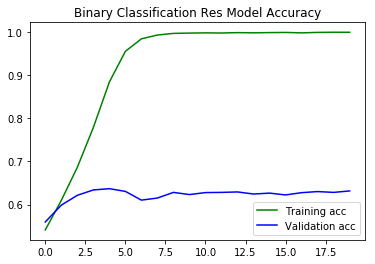

In [81]:
binary_acc = binary_history.history['acc']
binary_val_acc = binary_history.history['val_acc']

binary_epochs = range(len(binary_acc))

plt.plot(binary_epochs, binary_acc, 'g', label='Training acc')
plt.plot(binary_epochs, binary_val_acc, 'b', label='Validation acc')
plt.title('Binary Classification Res Model Accuracy')
plt.legend()

### Hyperparameter Tuning

In [37]:
# generic way to create custom callback
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [38]:
# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001, 0.0001]

# callback to append loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
    # model and generators
    model_tuning = cnn_model()
    model_tuning.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator, validation_generator = data_generator(b_train_X, b_train_set, b_test_X, b_test_set,classes=b_nb_classes,ablation=100)
    model_tuning.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=3, callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Counter({1: 53, 0: 47})
Counter({0: 55, 1: 45})
Epoch 1/3
10/10 [==============================] - 35s 4s/step - loss: 0.7116 - acc: 0.5400 - val_loss: 0.6797 - val_acc: 0.5700
Epoch 2/3
10/10 [==============================] - 5s 460ms/step - loss: 0.5473 - acc: 0.7400 - val_loss: 1.3316 - val_acc: 0.4900
Epoch 3/3
10/10 [==============================] - 5s 460ms/step - loss: 0.2817 - acc: 0.9000 - val_loss: 1.0277 - val_acc: 0.5800


========================================   Checking for LR=0.01  ========================================
Counter({0: 52, 1: 48})
Counter({0: 54, 1: 46})
Epoch 1/3
10/10 [==============================] - 36s 4s/step - loss: 0.7131 - acc: 0.4500 - val_loss: 0.7015 - val_acc: 0.4700
Epoch 2/3
10/10 [==============================] - 5s 488ms/step - loss: 0.6990 - acc: 0.5600 - val_loss: 0.6981 - val_acc: 0.4700
Epoch 3/3
10/10 [=====================

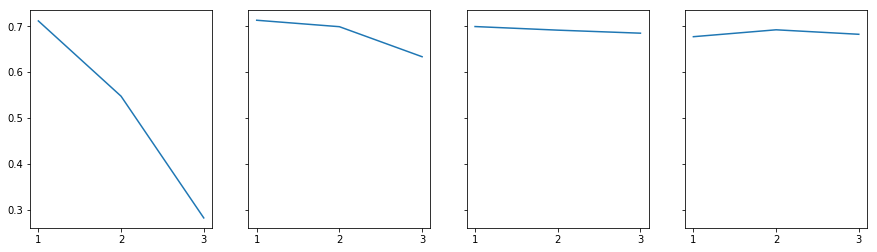

In [39]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

In [ ]:
# # Utility function for obtaining of the errors 
# def obtain_errors(val_generator, predictions):
#     # Get the filenames from the generator
#     fnames = validation_generator.filenames

#     # Get the ground truth from generator
#     ground_truth = validation_generator.classes

#     # Get the dictionary of classes
#     label2index = validation_generator.class_indices

#     # Obtain the list of the classes
#     idx2label = list(label2index.keys())
#     print("The list of classes: ", idx2label)

#     # Get the class index
#     predicted_classes = np.argmax(predictions, axis=1)

#     errors = np.where(predicted_classes != ground_truth)[0]
#     print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
#     return idx2label, errors, fnames


# # Utility function for visualization of the errors
# def show_errors(idx2label, errors, predictions, fnames):
#     # Show the errors
#     for i in range(len(errors)):
#         pred_class = np.argmax(predictions[errors[i]])
#         pred_label = idx2label[pred_class]

#         title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
#             fnames[errors[i]].split('/')[0],
#             pred_label,
#             predictions[errors[i]][pred_class])

#         original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
#         plt.figure(figsize=[7,7])
#         plt.axis('off')
#         plt.title(title)
#         plt.imshow(original)
#         plt.show()

### Binary Base Model Evaluation

In [ ]:
# test_X = random.sample(b_test_X, 100)
# test_set = {image: b_test_set[image] for image in test_X }

In [ ]:
len(test_set)

In [82]:
binary_test_generator = DataGenerator(b_test_X, b_test_set,n_classes=2,shuffle=False)

In [83]:
#Load the best model
binary_eval_base_model = load_model(binary_filepath)
#binary_eval_base_model = load_model('/mnt/disks/user/project/Final_Models/res_binary_best_modelv2_val65.hdf5')

In [84]:
#x,y = binary_test_generator[0]

In [85]:
binary_predictions = binary_eval_base_model.predict_generator(binary_test_generator)
#binary_predictions = binary_res_model.predict_generator(binary_test_generator)
#binary_predictions = binary_eval_base_model.predict(binary_test_generator)

In [86]:
np.array(list(binary_test_generator.classes.values()))[binary_test_generator.indexes]

array([0, 0, 0, ..., 1, 1, 1])

In [87]:
np.array(list(binary_test_generator.classes.values()))[:len(binary_predictions)]

array([0, 0, 0, ..., 1, 1, 1])

In [88]:
binary_y_class = np.array(list(binary_test_generator.classes.values()))[:len(binary_predictions)]
binary_y = keras.utils.to_categorical(binary_y_class, num_classes=b_nb_classes)

In [89]:
binary_prob_max = binary_predictions.max(axis=1).reshape(-1, 1)
binary_y_pred = np.where(binary_predictions == binary_prob_max, 1, 0)

In [90]:
binary_pred = np.argmax(binary_predictions, axis=-1)

In [91]:
len(binary_y_pred)

2368

In [92]:
len(binary_y)

2368

In [93]:
binary_y_class

array([0, 0, 0, ..., 1, 1, 1])

In [94]:
binary_pred

array([0, 0, 0, ..., 0, 0, 1])

In [95]:
Counter(binary_pred)

Counter({0: 1427, 1: 941})

In [96]:
binary_score_test = metrics.accuracy_score(binary_y, binary_y_pred)
print('Res Model Test Score ',binary_score_test)

Res Model Test Score  0.6351351351351351


In [97]:
binary_cm = confusion_matrix(binary_y_class, binary_pred)
print(binary_cm)

[[881 318]
 [546 623]]


In [98]:
binary_report = classification_report(binary_y,binary_y_pred)
print(binary_report)

             precision    recall  f1-score   support

          0       0.62      0.73      0.67      1199
          1       0.66      0.53      0.59      1169

avg / total       0.64      0.64      0.63      2368



In [99]:
roc_auc_score(binary_y, binary_y_pred)

0.6338565571109658

## Multi-Class Res Classification Models

In [103]:
def cnn_model(in_shape=(224,224,3)):
    model = Sequential()
    model.add(res_base)
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.6))
#     model.add(Conv2D(64,(3,3),strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(m_nb_classes, activation='softmax'))
    
    return model

#call define model
multi_res_model = cnn_model()
multi_res_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 64)          1179712   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 195       
Total params: 24,767,619
Trainable params: 24,704,899
Non-trainable params: 62,720
___________________________________________________________

In [104]:
sgd = optimizers.SGD(lr=0.005, momentum=0.5, decay = 0.001)

In [105]:
m_training_generator, m_validation_generator = data_generator(m_train_X, m_train_set, m_test_X, m_test_set,classes=m_nb_classes)
multi_res_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Counter({0: 599, 1: 599, 2: 599})
Counter({0: 1401, 1: 1401, 2: 1401})


In [106]:
# checkpoint 
multi_filepath = '/mnt/disks/user/project/Final_Models/multi_res_best_model.hdf5'
checkpoint = ModelCheckpoint(multi_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()
# fit: this will fit the net on 'ablation' samples, only 1 epoch
multi_history = multi_res_model.fit_generator(generator = m_training_generator,
                    validation_data = m_validation_generator,
                    shuffle=True,
                    epochs=20,
                    callbacks=[checkpoint])

Epoch 1/20
130/131 [============================>.] - ETA: 1s - loss: 0.8880 - acc: 0.5942
Epoch 00001: val_acc improved from -inf to 0.51730, saving model to /mnt/disks/user/project/Final_Models/multi_res_best_model.hdf5
131/131 [==============================] - 175s 1s/step - loss: 0.8868 - acc: 0.5949 - val_loss: 1.0050 - val_acc: 0.5173
Epoch 2/20
130/131 [============================>.] - ETA: 0s - loss: 0.5197 - acc: 0.7873
Epoch 00002: val_acc did not improve from 0.51730
131/131 [==============================] - 121s 924ms/step - loss: 0.5207 - acc: 0.7872 - val_loss: 1.1931 - val_acc: 0.5067
Epoch 3/20
130/131 [============================>.] - ETA: 0s - loss: 0.2853 - acc: 0.8913
Epoch 00003: val_acc did not improve from 0.51730
131/131 [==============================] - 121s 923ms/step - loss: 0.2847 - acc: 0.8915 - val_loss: 1.5150 - val_acc: 0.5123
Epoch 4/20
130/131 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9582
Epoch 00004: val_acc did not impr

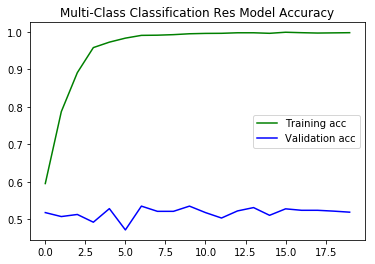

In [107]:
multi_acc = multi_history.history['acc']
multi_val_acc = multi_history.history['val_acc']

multi_epochs = range(len(multi_acc))

plt.plot(multi_epochs, multi_acc, 'g', label='Training acc')
plt.plot(multi_epochs, multi_val_acc, 'b', label='Validation acc')
plt.title('Multi-Class Classification Res Model Accuracy')
plt.legend()

### Multi-Class Base Model Evaluation

In [108]:
multi_test_generator = DataGenerator(m_test_X, m_test_set,n_classes=m_nb_classes,shuffle=False)

In [109]:
#Load the best model
multi_eval_base_model = load_model(multi_filepath)

In [110]:
multi_predictions = multi_eval_base_model.predict_generator(multi_test_generator)

In [111]:
multi_y_class = np.array(list(multi_test_generator.classes.values()))[:len(multi_predictions)]
multi_y = keras.utils.to_categorical(multi_y_class, num_classes=m_nb_classes)

In [112]:
multi_prob_max = multi_predictions.max(axis=1).reshape(-1, 1)
multi_y_pred = np.where(multi_predictions == multi_prob_max, 1, 0)

In [113]:
multi_pred = np.argmax(multi_predictions, axis=-1)

In [114]:
len(multi_y_pred)

1792

In [115]:
len(multi_y)

1792

In [116]:
Counter(multi_pred)

Counter({0: 825, 2: 809, 1: 158})

In [117]:
multi_score_test = metrics.accuracy_score(multi_y, multi_y_pred)
print('Multi-Class Res Model Test Score ',multi_score_test)

Multi-Class Res Model Test Score  0.5323660714285714


In [118]:
multi_cm = confusion_matrix(multi_y_class, multi_pred)
print(multi_cm)

[[405  15 179]
 [282 118 199]
 [138  25 431]]


In [119]:
multi_report = classification_report(multi_y,multi_y_pred)
print(multi_report)

             precision    recall  f1-score   support

          0       0.49      0.68      0.57       599
          1       0.75      0.20      0.31       599
          2       0.53      0.73      0.61       594

avg / total       0.59      0.53      0.50      1792

